Task1

In [1]:
import pandas as pd
import numpy as np

train = pd.read_csv('./dataset/train.csv')
train.head()

,id,dt,type,target
0,00037f39cf,11,2,44.050
1,00037f39cf,12,2,50.672
2,00037f39cf,13,2,39.042
3,00037f39cf,14,2,35.900
4,00037f39cf,15,2,53.888


|特征字段|	字段描述|
|--|--|
|id	|房屋id|
|dt	|日标识|
|type	|房屋类型|
|target	|实际电力消耗，预测目标|

In [2]:
test = pd.read_csv("./dataset/test.csv")
test.head()

,id,dt,type
0,00037f39cf,1,2
1,00037f39cf,2,2
2,00037f39cf,3,2
3,00037f39cf,4,2
4,00037f39cf,5,2


In [3]:
# 3. 计算训练数据最近11-20单位时间内对应id的目标均值
target_mean = train[train["dt"] <= 20].groupby(["id"])["target"].mean().reset_index()

# 4. 将target_mean作为测试集结果进行合并
test = test.merge(target_mean, on=["id"], how="left")

# 5. 保存结果文件到本地
test[["id", "dt", "target"]].to_csv("submit.csv", index=None)

Task 2

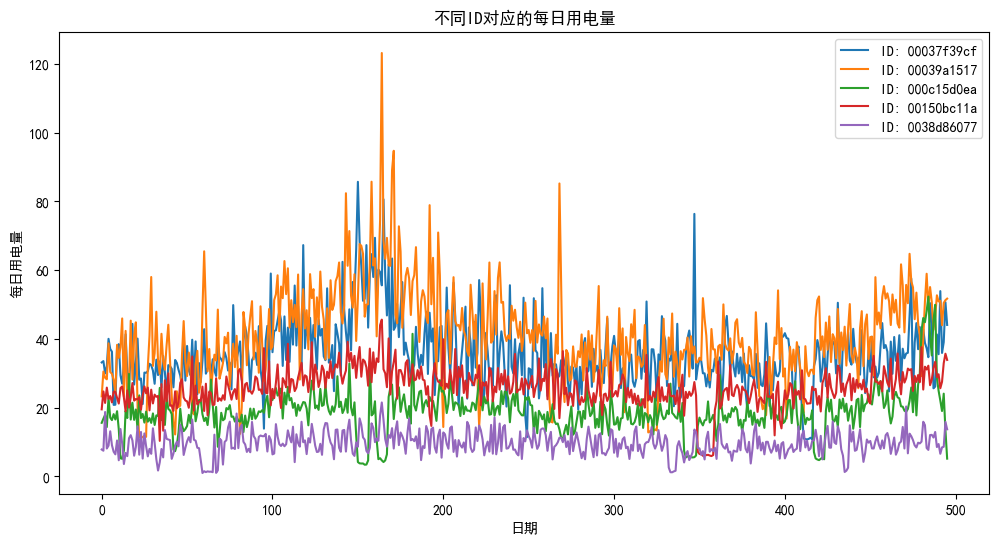

In [4]:
# 先查看数据是否存在规律
import matplotlib.pyplot as plt

plt.rcParams["font.sans-serif"] = ["SimHei"]  # 用来正常显示中文标签
plt.rcParams["axes.unicode_minus"] = False  # 用来正常显示负号

def draw_pic(data):
    unique_ids = data["id"].unique()
    plt.figure(figsize=(12,6))

    for id in unique_ids[:5]:
        demo_data = data[data["id"] == id]
        # 为了更直观理解图像,将target翻转,题目含义是距离当天的时间,那么反过来就是历史时间,
        # 例如0就会对应第一天,1对应第二天,一直到496天,然后通过496天数据来预测未来10天数据.
        plt.plot(demo_data["target"].tolist()[::-1], label=f"ID: {id}")
    plt.legend()
    plt.title('不同ID对应的每日用电量')
    plt.xlabel('日期')
    plt.ylabel('每日用电量')
    plt.show()

draw_pic(train)

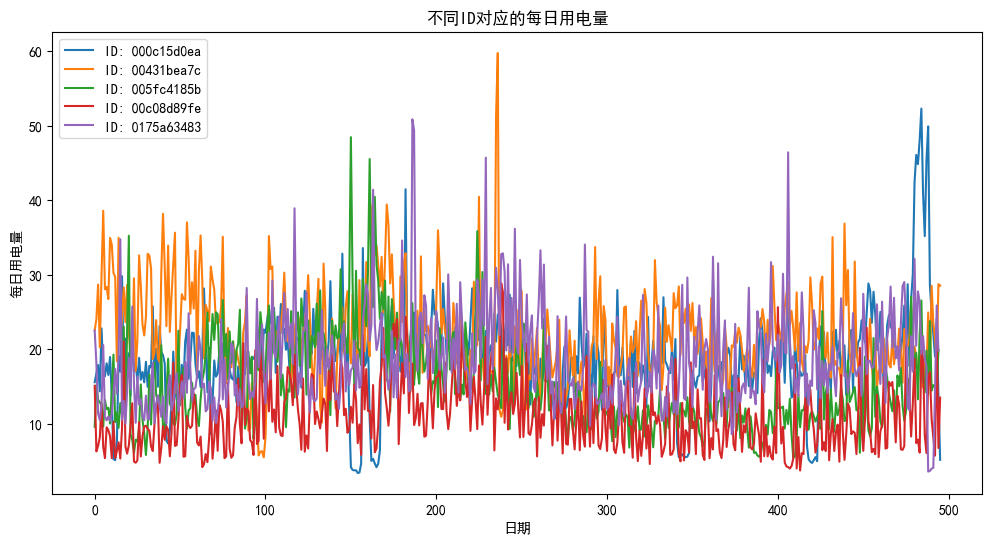

In [5]:
# 也许不同的type类型也有影响?

same_type_train = train[train['type']==0]
draw_pic(same_type_train)

完全看不出规律!

In [6]:
# 直接上工具LightGBM
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import (
    mean_squared_log_error,
    mean_absolute_error,
    mean_squared_error,
)
import tqdm
import sys
import os
import gc
import argparse
import warnings

warnings.filterwarnings("ignore")

In [7]:
train = pd.read_csv("./dataset/train.csv")
test = pd.read_csv("./dataset/test.csv")
train.head()

,id,dt,type,target
0,00037f39cf,11,2,44.050
1,00037f39cf,12,2,50.672
2,00037f39cf,13,2,39.042
3,00037f39cf,14,2,35.900
4,00037f39cf,15,2,53.888


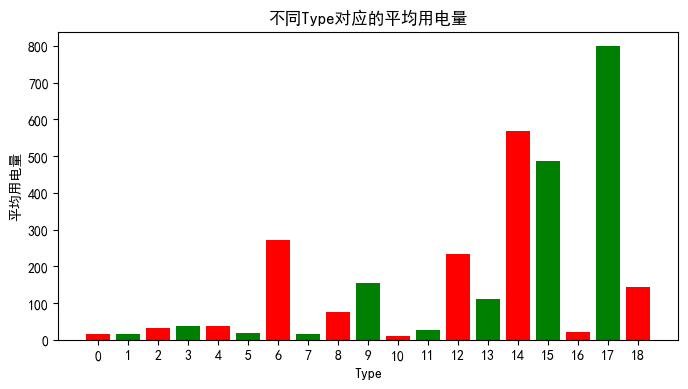

In [8]:
import matplotlib.pyplot as plt

# 不同type类型对应target的柱状图
type_target_df = train.groupby("type")["target"].mean().reset_index()
plt.figure(figsize=(8, 4))
plt.bar(type_target_df["type"], type_target_df["target"], color=["red", "green"])

# 18个type对应的平均用电量
plt.xlabel("Type")
plt.xticks([i for i in range(0,19)])
plt.ylabel("平均用电量")
plt.title("不同Type对应的平均用电量")
plt.show()

In [9]:
# 合并训练数据和测试数据，并进行排序
data = pd.concat([test, train], axis=0, ignore_index=True)
data = data.sort_values(["id", "dt"], ascending=False).reset_index(drop=True)

# 历史平移
for i in range(10, 30):
    data[f"last{i}_target"] = data.groupby(["id"])["target"].shift(i)

# 窗口统计
data[f"win7_mean_target"] = (
    data["last10_target"]
    + data["last11_target"]
    + data["last12_target"]
    + data["last13_target"]
    + data["last14_target"]
    + data["last15_target"]
    + data["last16_target"]
) / 7

# 进行数据切分
train = data[data.target.notnull()].reset_index(drop=True)
test = data[data.target.isnull()].reset_index(drop=True)

# 确定输入特征
train_cols = [f for f in data.columns if f not in ["id", "target"]]

In [10]:
data.iloc[10:20,:]

,id,dt,type,target,last10_target,last11_target,last12_target,last13_target,last14_target,last15_target,...,last21_target,last22_target,last23_target,last24_target,last25_target,last26_target,last27_target,last28_target,last29_target,win3_mean_target
10,fff81139a7,496,5,23.288,18.145,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,fff81139a7,495,5,25.252,22.021,18.145,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,fff81139a7,494,5,16.963,21.282,22.021,18.145,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.482667
13,fff81139a7,493,5,29.759,22.818,21.282,22.021,18.145,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.040333
14,fff81139a7,492,5,16.652,28.552,22.818,21.282,22.021,18.145,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.217333
15,fff81139a7,491,5,20.809,22.296,28.552,22.818,21.282,22.021,18.145,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.555333
16,fff81139a7,490,5,25.967,27.112,22.296,28.552,22.818,21.282,22.021,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.986667
17,fff81139a7,489,5,25.936,25.968,27.112,22.296,28.552,22.818,21.282,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.125333
18,fff81139a7,488,5,26.860,24.015,25.968,27.112,22.296,28.552,22.818,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.698333
19,fff81139a7,487,5,30.358,21.006,24.015,25.968,27.112,22.296,28.552,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.663000


In [11]:
def time_model(lgb, train_df, test_df, cols):
    # 训练集和验证集切分
    trn_x, trn_y = (
        train_df[train_df.dt >= 31][cols],
        train_df[train_df.dt >= 31]["target"],
    )
    val_x, val_y = (
        train_df[train_df.dt <= 30][cols],
        train_df[train_df.dt <= 30]["target"],
    )
    # 构建模型输入数据
    train_matrix = lgb.Dataset(trn_x, label=trn_y)
    valid_matrix = lgb.Dataset(val_x, label=val_y)
    # lightgbm参数
    lgb_params = {
        "boosting_type": "gbdt",
        "objective": "regression",
        "metric": "mse",
        "min_child_weight": 5,
        "num_leaves": 2**5,
        "lambda_l2": 10,
        "feature_fraction": 0.8,
        "bagging_fraction": 0.8,
        "bagging_freq": 4,
        "learning_rate": 0.05,
        "seed": 2024,
        "nthread": 16,
        "verbose": -1,
    }
    # 训练模型
    model = lgb.train(
        lgb_params,
        train_matrix,
        50000,
        valid_sets=[train_matrix, valid_matrix],
        categorical_feature=[],
        verbose_eval=500,
        early_stopping_rounds=500,
    )
    # 验证集和测试集结果预测
    val_pred = model.predict(val_x, num_iteration=model.best_iteration)
    test_pred = model.predict(test_df[cols], num_iteration=model.best_iteration)
    # 离线分数评估
    score = mean_squared_error(val_pred, val_y)
    print(score)

    return val_pred, test_pred


lgb_oof, lgb_test = time_model(lgb, train, test, train_cols)

# 保存结果文件到本地
test["target"] = lgb_test
test[["id", "dt", "target"]].to_csv("submit.csv", index=None)

Training until validation scores don't improve for 500 rounds
[500]	training's l2: 181.756	valid_1's l2: 185.818
[1000]	training's l2: 170.758	valid_1's l2: 183.924
Early stopping, best iteration is:
[956]	training's l2: 171.445	valid_1's l2: 183.578
183.5783792507079
